In [74]:
# Imports cell

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from shutil import copyfile, rmtree
from pathlib import Path
from glob import glob
import itertools
import warnings

warnings.filterwarnings("ignore")

In [75]:
# Directory of all 20 classes
INPUT_CLASSES_DIR = "./Species/Training_Set/"
folders = glob(INPUT_CLASSES_DIR + '/*')
n_classes = len(folders)

# Number of samples per class for training (less than 1700)
TRAIN_SAMPLE_SIZE = 200

# Number of samples per class for testing (less than 300)
TEST_SAMPLE_SIZE = 20

In [76]:
# Copy all images to use for training and testing

test_root = "./test"
train_root = "./train"

rmtree(train_root, ignore_errors=True)
rmtree(test_root, ignore_errors=True)

for dirname in folders:
    current_subfolder = dirname.split("/")[-1]
    folder_sample = random.sample(glob(dirname + "/*"), TRAIN_SAMPLE_SIZE + TEST_SAMPLE_SIZE)
    Path(f"{test_root}/{current_subfolder}").mkdir(parents=True, exist_ok=True)
    Path(f"{train_root}/{current_subfolder}").mkdir(parents=True, exist_ok=True)
    train_filenames = folder_sample[:TRAIN_SAMPLE_SIZE]
    for f in train_filenames:
        copyfile(f, f"{train_root}/{current_subfolder}/{f.split('/')[-1]}")
    test_filenames = folder_sample[TRAIN_SAMPLE_SIZE:]
    for f in test_filenames:
        copyfile(f, f"{test_root}/{current_subfolder}/{f.split('/')[-1]}")

train_files = glob(train_root + "/*/*.jp*g")
test_files = glob(test_root + "/*/*.jp*g")

print(len(train_files))
print(len(test_files))

4000
400


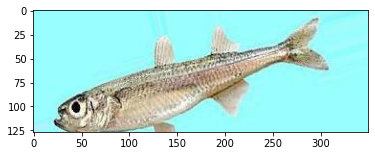

In [77]:
plt.imshow(image.load_img(np.random.choice(train_files)))

In [78]:
# ResNet50 network
image_size = [200, 200]
resnet = ResNet50(input_shape=image_size + [3], weights="imagenet", include_top=False)

# Make ResNet weights non trainable
for layer in resnet.layers:
    layer.trainable = False

# Print summary
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [79]:
# Chain a neural network at the end
x = Flatten()(resnet.output)
prediction = Dense(n_classes, activation="softmax")(x)

# Full model using the Functional API
model = Model(inputs=resnet.input, outputs=prediction)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [80]:
# Compile the model using appropriate loss and optimizer
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=["accuracy"])

In [85]:
# Create ImageDataGenerator objects for training and testing

batch_size = 128

train_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_gen.flow_from_directory(
    train_root,
    target_size=image_size,
    shuffle=True,
    batch_size=batch_size,
    class_mode="sparse",
)

valid_generator = val_gen.flow_from_directory(
    test_root,
    target_size=image_size,
    shuffle=False,
    batch_size=batch_size,
    class_mode="sparse",
)

test_gen = val_gen.flow_from_directory(
    test_root, 
    target_size=image_size
)

Found 4000 images belonging to 20 classes.
Found 400 images belonging to 20 classes.
Found 400 images belonging to 20 classes.


In [86]:
### Translate labels into species

labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

In [87]:
# Fit the model

epochs = 20
callback = EarlyStopping(monitor="loss", patience=3)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[callback]
)

Epoch 1/20
15/32 [=============>................] - ETA: 2:17 - loss: 18.0787 - accuracy: 0.3354

KeyboardInterrupt: 

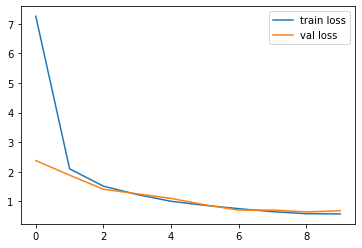

In [109]:
plt.plot(r.history['loss'], label='train loss')
if 'val_loss' in r.history:
    plt.plot(r.history['val_loss'], label='val loss')
plt.legend()

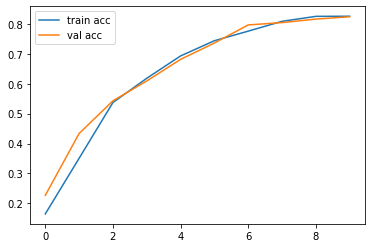

In [110]:
plt.plot(r.history['accuracy'], label='train acc')
if 'val_accuracy' in r.history:
    plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()

In [111]:
model.evaluate(valid_generator)

5/5 [==============================] - 7s 1s/step - loss: 0.6639 - accuracy: 0.8283


[0.6638641953468323, 0.82833331823349]

In [112]:
preds = model.predict(valid_generator)
classes = [x.split('/')[-1] for x in folders]

Predicted: Anthias anthias
Real class: Anthias anthias


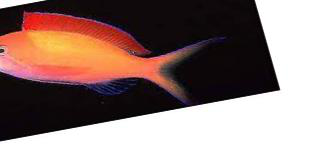

In [117]:
idx = np.random.choice(len(test_files))
samples = np.array(test_files)[idx]
pred_samples = preds[idx]
print("Predicted: " + classes[pred_samples.argmax()])
print("Real class: " + samples.split("/")[2])
image.load_img(samples)